<a href="https://colab.research.google.com/github/kolbrak/Strava_Clustering/blob/master/Strava_Ride_Data_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What was I trying to do?
1. Practice clustering on a real world dataset.
2. See if there were insights that would improve my cycling hobby.

## What did I learn from creating this analysis?
1. Preprocessing your data takes a lot longer than creating the model
2. Understanding the dataset is essential.  I originally created the model with an assumption that the start time was in my time zone.  It wasn't until I started to look at the data that I realized they transform all start times to UTC.  So I was 5 hours off!
3. Understanding the data allowed creation of an additional derived data set

## So what do I conclude from this clustering analysis?
1. I ride a lot in the morning and after work betwen 5-10 miles
2. I do long rides more often early in the day vs late in the day
3. I need to do more long rides


In [0]:
# Import all the things we need ---
%matplotlib inline
import os,random
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
#force_remount=True

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#This line checks that the drive was mounted
!ls "/content/gdrive/My Drive/Colab Notebooks/"

 activities.csv			 model.json
 activities.gsheet		 model.png
 Baseball.ipynb			 Modulation_Classification.ipynb
 daily-total-female-births.txt	 RML2016.10a_dict.pkl
 kmeans.py			'Strava Ride Data Clustering.ipynb'
 model.h5			 Time_series_prediction.ipynb


In [3]:
#Import the dataset
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/activities.csv')
df.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Relative Effort,Commute,Activity Gear,Filename
0,99431348,"Dec 9, 2013, 5:24:54 PM",Morning Ride,Ride,NaN,3161,22.15,NaN,False,NaN,activities/99431348.gpx
1,99498058,"Dec 10, 2013, 3:49:21 AM",Afternoon Ride,Ride,NaN,2220,12.62,NaN,False,NaN,activities/99498058.gpx
2,99878523,"Dec 12, 2013, 5:18:58 PM",Morning Ride,Ride,NaN,3261,22.12,NaN,False,NaN,activities/99878523.gpx
3,100661158,"Dec 17, 2013, 5:25:42 PM",Morning Ride,Ride,NaN,3583,22.50,NaN,False,NaN,activities/100661158.gpx
4,100742178,"Dec 18, 2013, 4:01:39 AM",Afternoon Ride,Ride,NaN,4067,22.70,NaN,False,NaN,activities/100742178.gpx


In [0]:
#Convert the date time to an Excel style time where it is the % of the day (ie 12:00 PM = 0.5)

def convert_to_time(strava_time):
  #time = df.iloc[1,1].split(' ', 4)[3].split(':',3)
  #am_pm = df.iloc[1,1].split(' ', 4)[4]
  time = strava_time.split(' ', 4)[3].split(':',3)
  am_pm = strava_time.split(' ', 4)[4]
  if am_pm == 'AM':
    time = int(time[0]) / 24 + int(time[1]) / (24 * 60)
    return (time * 24) - 5
  else:
    if int(time[0]) == 12:
      time[0] = int(time[0])
      time = int(time[0]) / 24 + int(time[1]) / (24 * 60)
      return (time * 24) - 5
    else:
      time[0] = int(time[0]) + 12
      time = int(time[0]) / 24 + int(time[1]) / (24 * 60)  
      return (time * 24) - 5

In [0]:
# Preprocessing the dataset
# This converts the elapsed workout time from seconds to minues
# Then converts the workout distance from km to miles
# Then converts the Activity date to time of day metric which is % complete of the day
# Rename unused data column and create an average speed column
# Calculte the average speed from the distance and elapsed time colunms

df['Elapsed Time'] = df['Elapsed Time'] / 60
df['Distance'] = df['Distance'] * 0.62137119 
df['Activity Date'] = df['Activity Date'].apply(convert_to_time)
df.rename(columns={'Activity Description':'Average Speed'}, inplace=True)
df['Average Speed'] = df['Distance'] / (df['Elapsed Time'] / 60)

In [0]:
# This selects what columns of data to use for the clustering
# Column 1 is time of day in % of the day
# Column 4 is the average speed column
# Column 5 is the duration in minutes
# Column 6 is the distance in miles

time_duration_distance = [1, 5, 6]
duration_distance_time = [5, 6, 1]
distance_time_duration = [6, 1, 5]
distance_duration_time = [6, 5, 1]
time_speed_distance = [1, 6, 4]

X = df.iloc[:, time_speed_distance].values

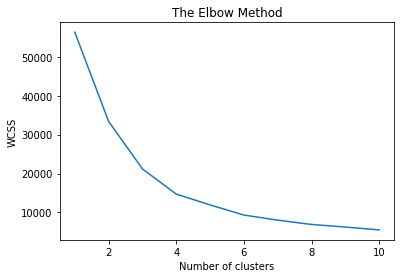

In [7]:
# Using the elbow method to find the optimal number of clusters

from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [0]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

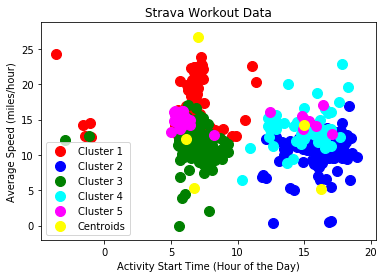

In [9]:
# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 2], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 2], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 2], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 2], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 2], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = 'yellow', s = 100, label = 'Centroids')
plt.title('Strava Workout Data')
plt.xlabel('Activity Start Time (Hour of the Day)')
plt.ylabel('Average Speed (miles/hour)')
plt.legend()
plt.show()

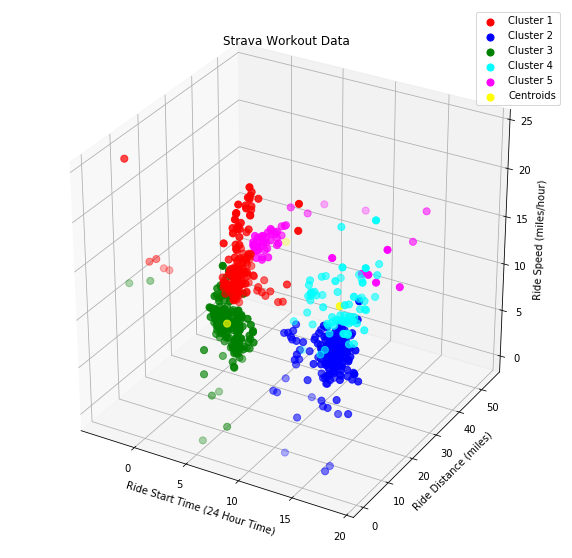

In [10]:
# import library for 3D plotting
from mpl_toolkits import mplot3d

plt.figure('Strava Data', figsize=(10,10))
ax = plt.axes(projection = '3d')
#ax.scatter(X[:,1],X[:,0],X[:,2], c='r' , cmap='Set2', s=50);
ax.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], X[y_kmeans == 0, 2], s = 50, c = 'red', label = 'Cluster 1')
ax.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], X[y_kmeans == 1, 2], s = 50, c = 'blue', label = 'Cluster 2')
ax.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], X[y_kmeans == 2, 2], s = 50, c = 'green', label = 'Cluster 3')
ax.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], X[y_kmeans == 3, 2], s = 50, c = 'cyan', label = 'Cluster 4')
ax.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], X[y_kmeans == 4, 2], s = 50, c = 'magenta', label = 'Cluster 5')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:,2], c = 'yellow', s = 50, label = 'Centroids')
ax.set_title('Strava Workout Data')
ax.set_xlabel('Ride Start Time (24 Hour Time)')
ax.set_ylabel('Ride Distance (miles)')
ax.set_zlabel('Ride Speed (miles/hour)')
ax.grid()
ax.legend()
# This will change the iso view perspective of the scatter plot view_init(elev, azim)
#ax.view_init(45, 45)
